#### **Import Libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


#### **Defining Image_size,Batch_size and Epochs**

In [2]:
IMAGE_SIZE=144
BATCH_SIZE=20
EPOCHS=50
CHANNELS=3
EPOCHS=50

#### **Reading the train dataset**

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/train",
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    # color_mode='grayscale'
)

Found 11879 files belonging to 2 classes.


In [4]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### **Reading the test dataset**

In [5]:
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/test",
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 2 classes.


In [6]:
class_names=dataset.class_names
class_names

['Benign', 'Malignant']

In [7]:
len(dataset)

594

#### **Plotting Image for two different class**

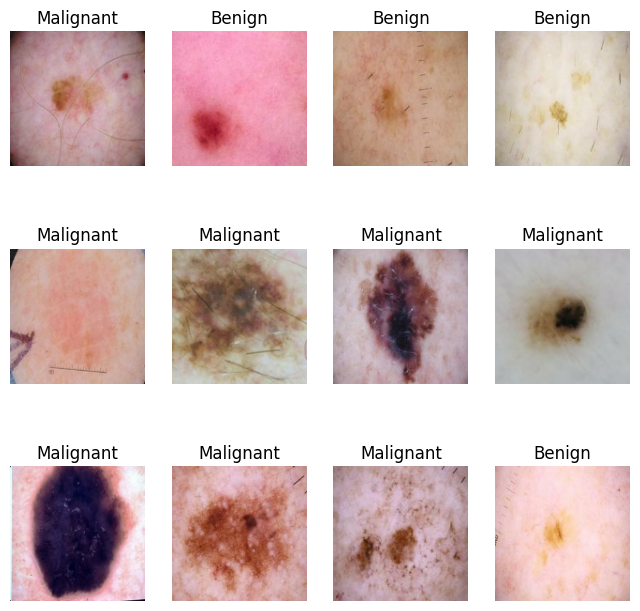

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

for image_batch, label_batch in dataset.take(1):
    if len(image_batch) < 12 or len(label_batch) < 12:
        print("Error: Batch size is smaller than 12")
        break

    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')  # Use cmap='gray' for grayscale images
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

plt.show()


#### **Train,validation and Test split**

In [9]:
def get_dataset_partitation(ds,train_split=0.8,valid_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+valid_split+test_split==1)
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(ds_size*train_split)
    test_size=int(ds_size*test_split)
    valid_size=int(ds_size*valid_split)
    train_ds=ds.take(train_size)
    valid_ds=ds.skip(train_size).take(valid_size)
    test_ds=ds.skip(train_size).skip(valid_size)

    return train_ds,valid_ds,test_ds

In [10]:
train_ds,valid_ds,test_ds=get_dataset_partitation(dataset)


In [11]:
len(train_ds)


475

In [12]:
len(test_ds)


60

In [13]:
len(valid_ds)


59

#### **Optimize Image fetching**

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds=valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### **Resize and Rescale**

In [15]:
resize_and_rescale=tf.keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.Rescaling(1./255)
    ]
)

#### **Data Augmentation**

In [16]:
data_augmentation=tf.keras.Sequential(
   [ layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3)]
)

#### **Model Building**

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


model.build(input_shape=input_shape)

c:\Users\AnsaB\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (20, 144, 144, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (20, 144, 144, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (20, 142, 142, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (20, 71, 71, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (20, 69, 69, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (20, 34, 34, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (20, 32, 32, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (20, 65536)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (20, 64)               │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (20, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,250,753 (16.22 MB)

 Trainable params: 4,250,753 (16.22 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 55s 106ms/step - accuracy: 0.6683 - loss: 0.6263 - val_accuracy: 0.8136 - val_loss: 0.4204
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 50s 104ms/step - accuracy: 0.8136 - loss: 0.4099 - val_accuracy: 0.8237 - val_loss: 0.3860
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 50s 104ms/step - accuracy: 0.8224 - loss: 0.3975 - val_accuracy: 0.8195 - val_loss: 0.3784
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 48s 101ms/step - accuracy: 0.8321 - loss: 0.3864 - val_accuracy: 0.8271 - val_loss: 0.3596
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 50s 106ms/step - accuracy: 0.8277 - loss: 0.3773 - val_accuracy: 0.8119 - val_loss: 0.3815
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 49s 103ms/step - accuracy: 0.8329 - loss: 0.3782 - val_accuracy: 0.8407 - val_loss: 0.3551
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 50s 106ms/step - accuracy: 0.8335 - loss: 0.3741 - val_accuracy: 0.8229 - val_loss: 0.3662
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 47s 100ms/step - accuracy: 0.8368 - loss: 0

#### **Model Accuracy Plot**

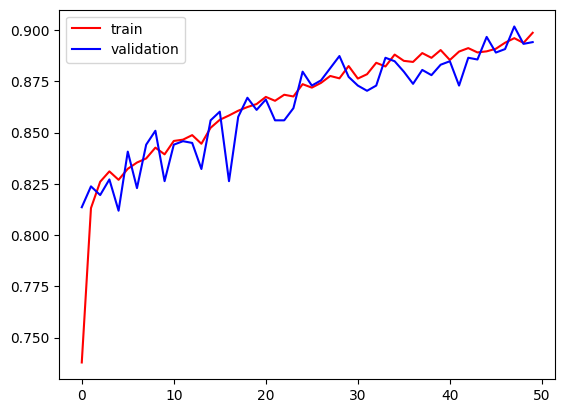

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

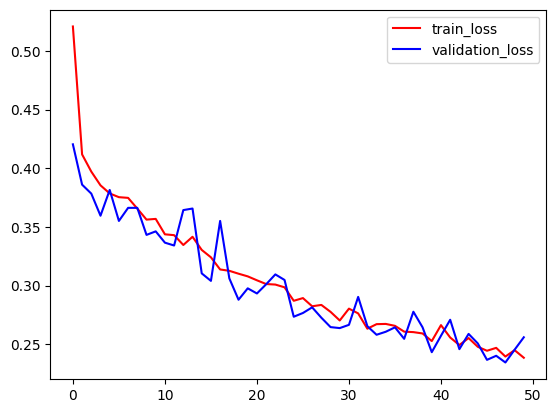

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train_loss')
plt.plot(history.history['val_loss'],color='blue',label='validation_loss')
plt.legend()
plt.show()

#### **Testing of train model**

In [23]:
scores=model.evaluate(test_ds)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8925 - loss: 0.2525


#### **Test dataset Accuracy**

In [24]:
scores_test=model.evaluate(test_dataset)

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9030 - loss: 0.2618


first image to predict
actual label: Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
predicted label: Benign


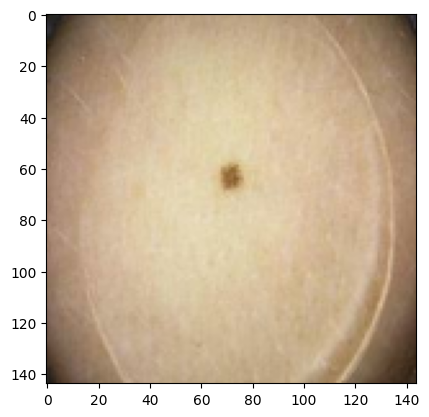

In [25]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image,cmap='gray')
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


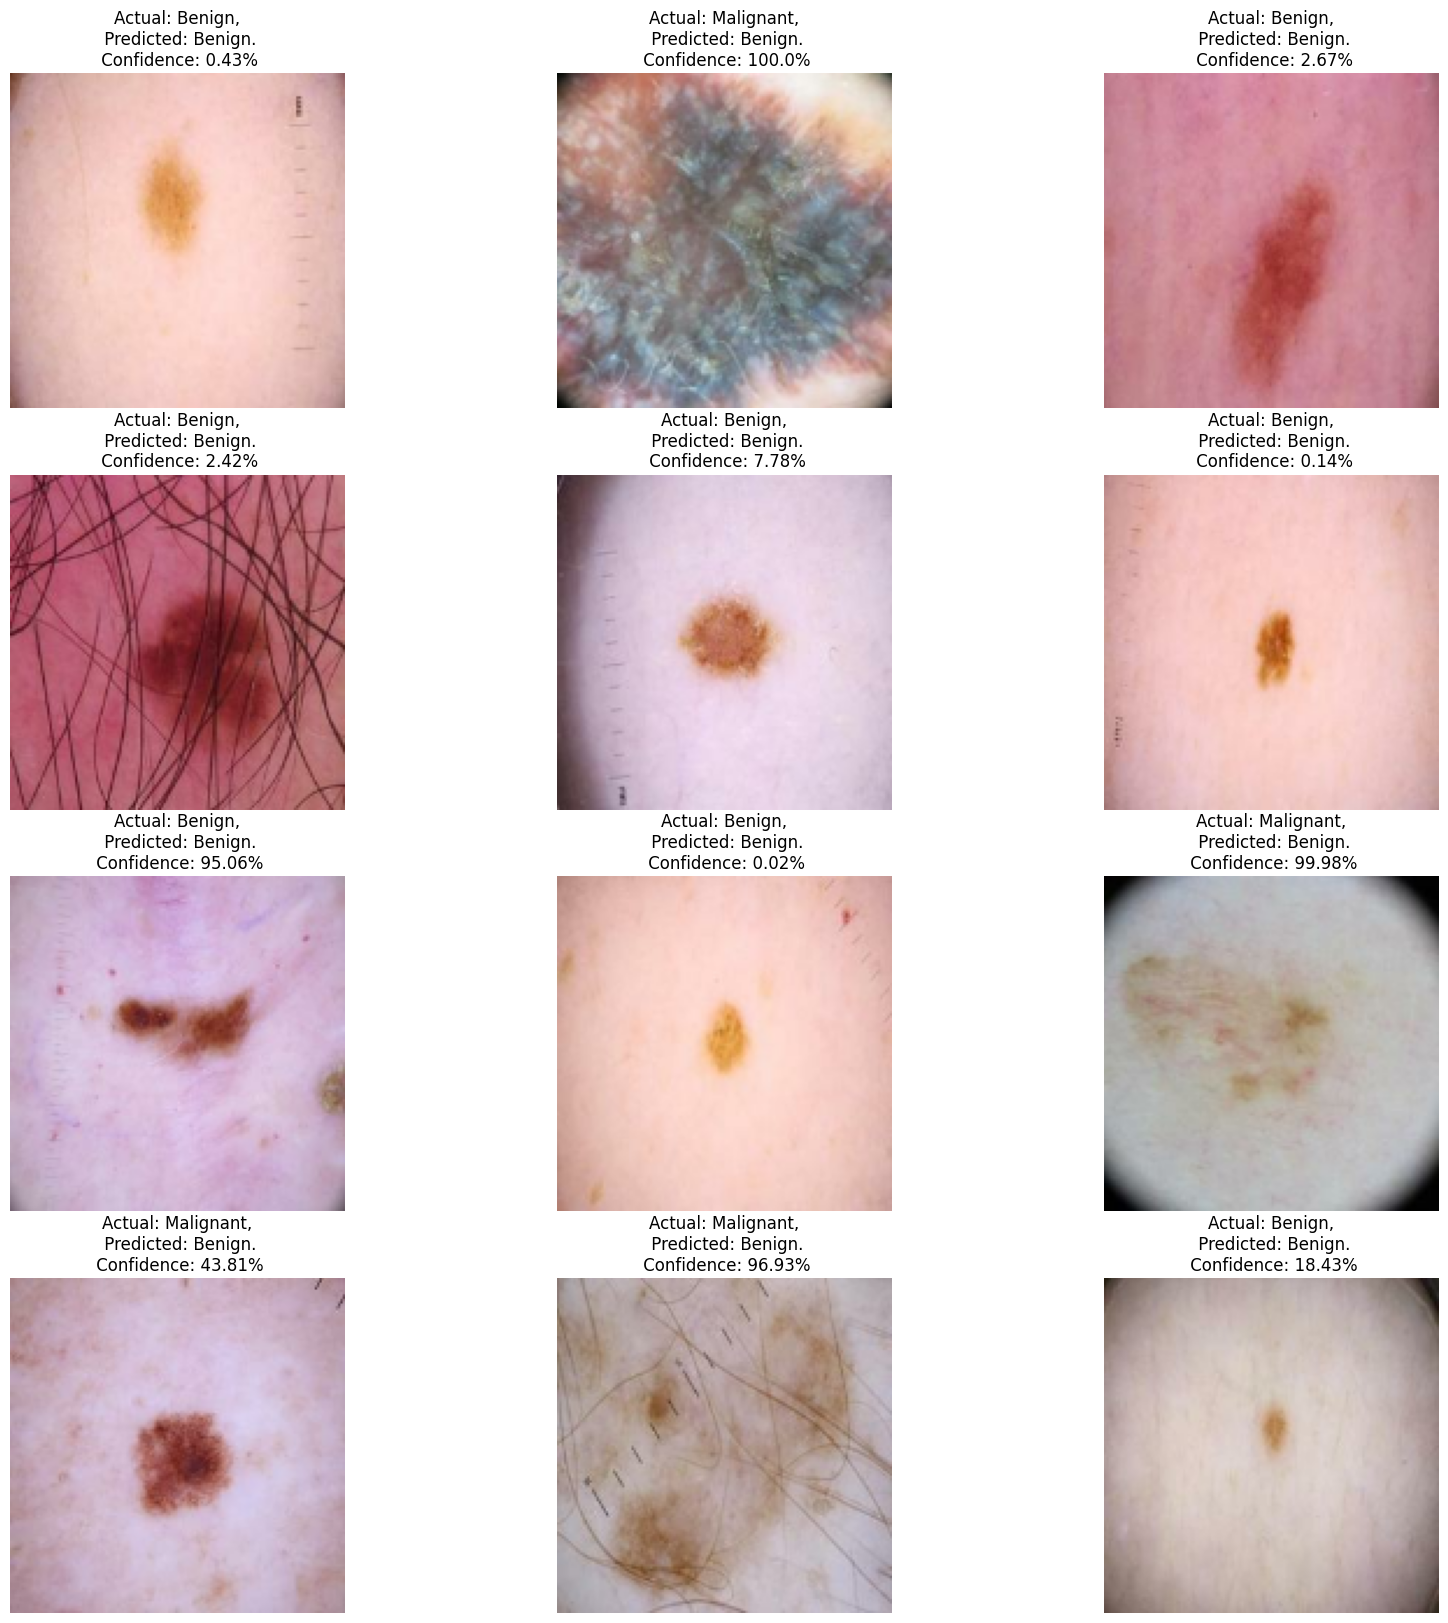

In [27]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

#### **Actual vs Predict Image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

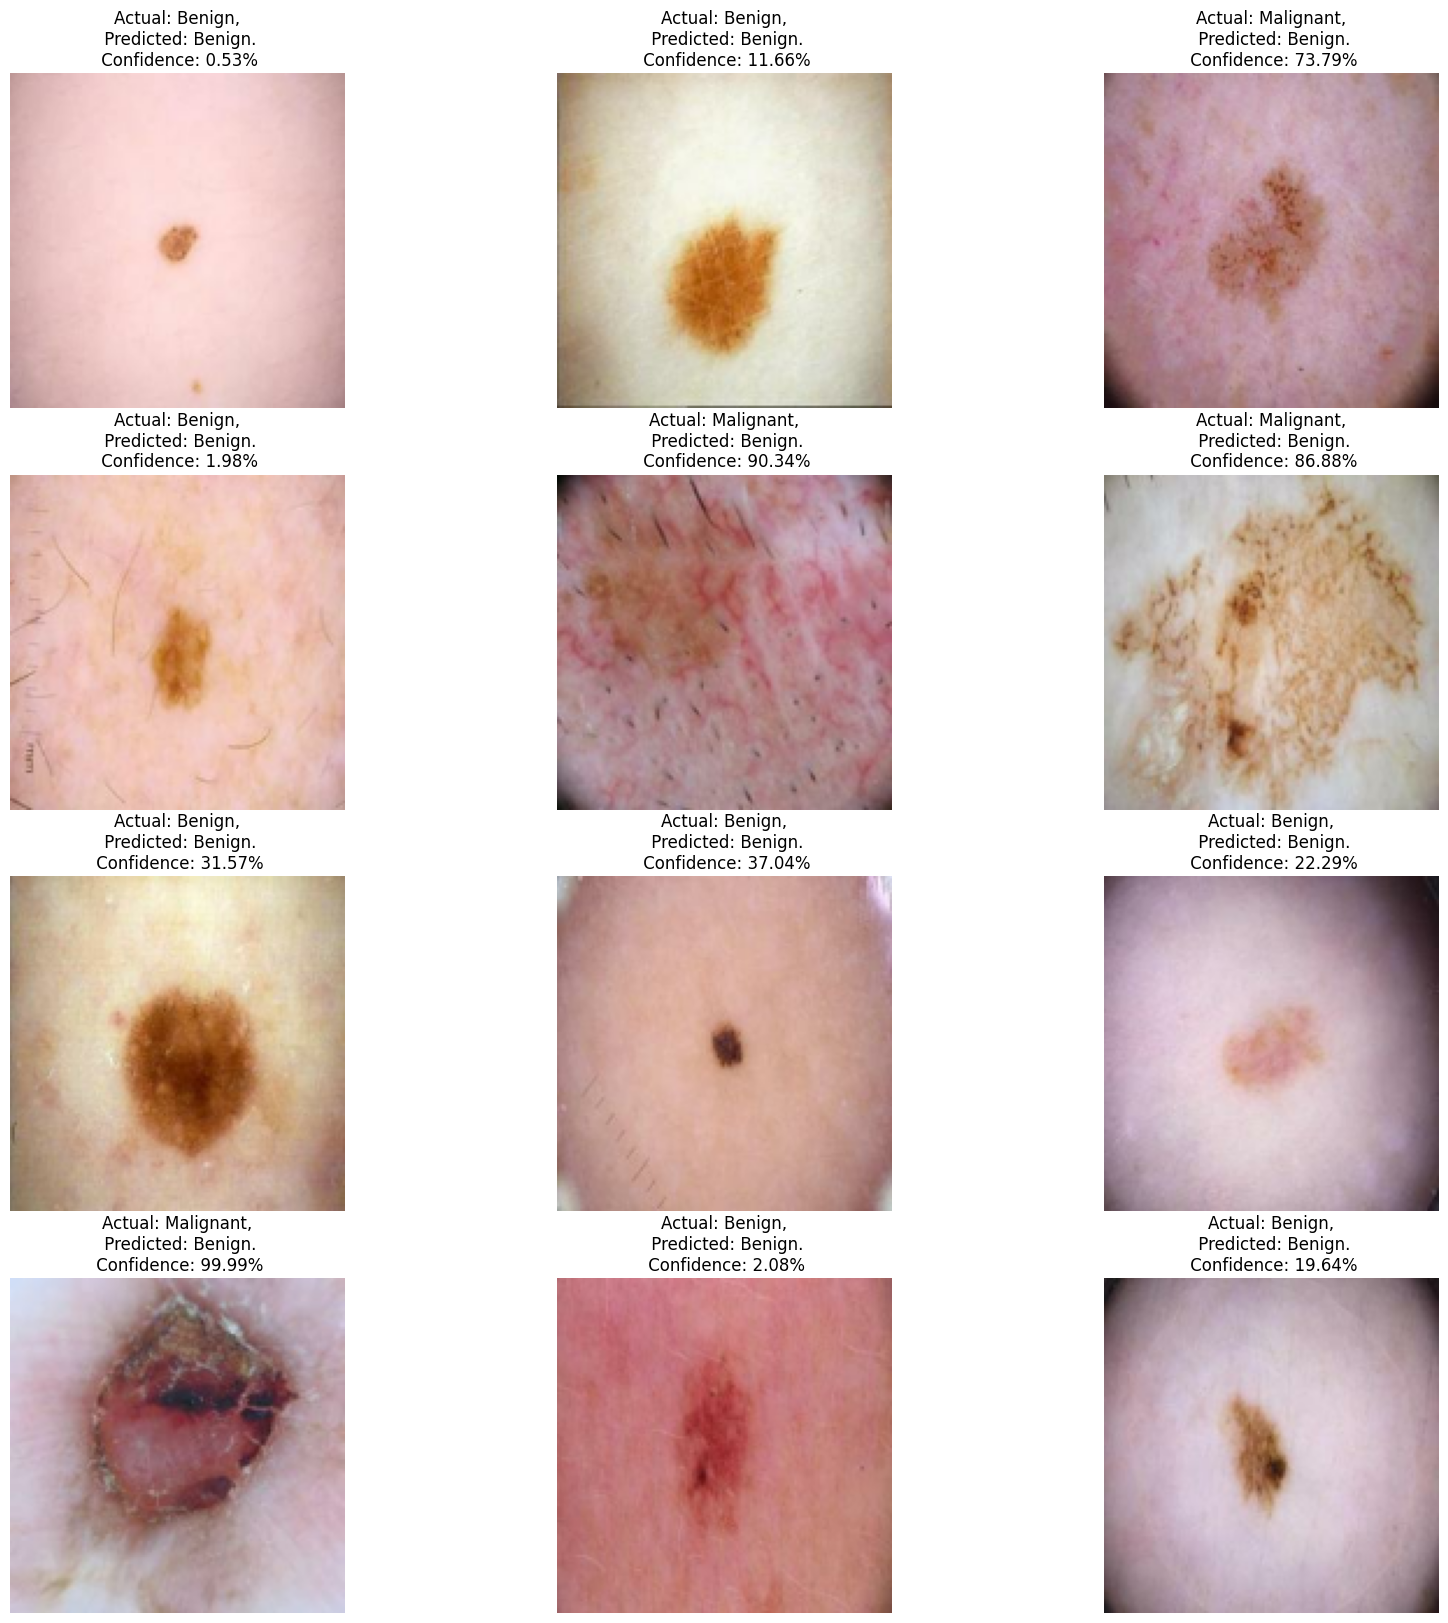

In [28]:
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(10):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### **Saving Model**

In [34]:
# Save the trained model to disk using TensorFlow's built-in method
model.save('trained_model.keras')

